In [3]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
import lightgbm as lgb
import numpy as np
import pandas as pd
import warnings
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.exceptions import ConvergenceWarning  # Importing ConvergenceWarning
import os

In [10]:
os.chdir("C:/Users/altaa/Documents/Apex-Legends-Dataset/Career_Stats_Dataset")
# Use correct relative paths for the CSV files
df_xbox = "Non Imputed Career Datasets/Career_Stats_Xbox.csv"
df_ps4 = "Non Imputed Career Datasets/Career_Stats_PS4.csv"
df_pc = "Non Imputed Career Datasets/Career_Stats_PC.csv"
# Read the CSV files
df_xbox = pd.read_csv(df_xbox)
df_ps4 = pd.read_csv(df_ps4)
df_pc = pd.read_csv(df_pc)


In [12]:
output_dir = r"C:\Users\altaa\Documents\Apex-Legends-Dataset\Career_Stats_Dataset\Imputated Datasets"
os.makedirs(output_dir, exist_ok=True)
# Instead of combining, process each dataset individually
datasets = {
    "Xbox": df_xbox,
    "PS4": df_ps4,
    "PC": df_pc
}

imputed_dataframes = {}

for name, df in datasets.items():
    print(f"Processing {name} dataset...")  # Debug print
    # Convert relevant columns to numeric
    df['career_kills'] = pd.to_numeric(df['career_kills'], errors='coerce')
    df['career_wins'] = pd.to_numeric(df['career_wins'], errors='coerce')
    df['career_revives'] = pd.to_numeric(df['career_revives'], errors='coerce')

    # Replace 0s with NaN to treat them as missing values
    df.replace(0, np.nan, inplace=True)

    # Drop the player_name column for imputation
    player_names = df['player_name']
    numeric_df = df.drop(columns=['player_name'])

    # Mode Imputation
    mode_imputer = SimpleImputer(strategy="most_frequent")
    df_mode_imputed = pd.DataFrame(mode_imputer.fit_transform(numeric_df), columns=numeric_df.columns)
    df_mode_imputed.insert(0, 'player_name', player_names)
    df_mode_imputed.iloc[:, 1:] = df_mode_imputed.iloc[:, 1:].round(0).astype(int)

    # Logistic Regression Imputation
    lr_imputer = IterativeImputer(estimator=LogisticRegression(solver='lbfgs'), random_state=42, max_iter=10, verbose=0)
    df_lr_imputed = pd.DataFrame(lr_imputer.fit_transform(numeric_df), columns=numeric_df.columns)
    df_lr_imputed.insert(0, 'player_name', player_names)
    df_lr_imputed.iloc[:, 1:] = df_lr_imputed.iloc[:, 1:].round(0).astype(int)

    # Random Forest Imputation
    rf_imputer = IterativeImputer(estimator=RandomForestClassifier(n_estimators=10), random_state=42, max_iter=10, verbose=0)
    df_rf_imputed = pd.DataFrame(rf_imputer.fit_transform(numeric_df), columns=numeric_df.columns)
    df_rf_imputed.insert(0, 'player_name', player_names)
    df_rf_imputed.iloc[:, 1:] = df_rf_imputed.iloc[:, 1:].round(0).astype(int)

    # KNN Imputation
    knn_imputer = KNNImputer(n_neighbors=5)
    df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(numeric_df), columns=numeric_df.columns)
    df_knn_imputed.insert(0, 'player_name', player_names)
    df_knn_imputed.iloc[:, 1:] = df_knn_imputed.iloc[:, 1:].round(0).astype(int)

    # Mean Imputation
    mean_imputer = SimpleImputer(strategy='mean')
    df_mean_imputed = pd.DataFrame(mean_imputer.fit_transform(numeric_df), columns=numeric_df.columns)
    df_mean_imputed.insert(0, 'player_name', player_names)
    df_mean_imputed.iloc[:, 1:] = df_mean_imputed.iloc[:, 1:].round(0).astype(int)

    # Median Imputation
    median_imputer = SimpleImputer(strategy='median')
    df_median_imputed = pd.DataFrame(median_imputer.fit_transform(numeric_df), columns=numeric_df.columns)
    df_median_imputed.insert(0, 'player_name', player_names)
    df_median_imputed.iloc[:, 1:] = df_median_imputed.iloc[:, 1:].round(0).astype(int)

    # XGBoost Imputation
    xgb_imputer = IterativeImputer(estimator=XGBRegressor(), random_state=42, max_iter=10, verbose=0)
    df_xgb_imputed = pd.DataFrame(xgb_imputer.fit_transform(numeric_df), columns=numeric_df.columns)
    df_xgb_imputed.insert(0, 'player_name', player_names)
    df_xgb_imputed.iloc[:, 1:] = df_xgb_imputed.iloc[:, 1:].round(0).astype(int)

    # MICE Imputation
    mice_imputer = IterativeImputer(max_iter=10, random_state=42)
    df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(numeric_df), columns=numeric_df.columns)
    df_mice_imputed.insert(0, 'player_name', player_names)
    df_mice_imputed.iloc[:, 1:] = df_mice_imputed.iloc[:, 1:].round(0).astype(int)

    # Store all rounded imputed dataframes for this dataset
    imputed_dataframes[name] = {
        "Mode Imputation": df_mode_imputed,
        "Logistic Regression Imputation": df_lr_imputed,
        "Random Forest Imputation": df_rf_imputed,
        "KNN Imputation": df_knn_imputed,
        "Mean Imputation": df_mean_imputed,
        "Median Imputation": df_median_imputed,
        "XGBoost Imputation": df_xgb_imputed,
        "MICE Imputation": df_mice_imputed
    }

    # Only save the MICE-imputed dataframe for this dataset to the specified directory
    mice_csv_path = os.path.join(output_dir, f"MICE_Imputed_{name}.csv")
    try:
        df_mice_imputed.to_csv(mice_csv_path, index=False)
        print(f"MICE-imputed dataset for {name} saved to {mice_csv_path}")
    except Exception as e:
        print(f"Failed to save {name}: {e}")

Processing Xbox dataset...


c:\Users\altaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\multiclass.py:213: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  y_type = type_of_target(y, input_name="y")
c:\Users\altaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\altaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\multiclass.py:213: UserWarning: The number of unique cla

MICE-imputed dataset for Xbox saved to C:\Users\altaa\Documents\Apex-Legends-Dataset\Career_Stats_Dataset\Imputated Datasets\MICE_Imputed_Xbox.csv
Processing PS4 dataset...


c:\Users\altaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\altaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\multiclass.py:213: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  y_type = type_of_target(y, input_name="y")
c:\Users\altaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs faile

MICE-imputed dataset for PS4 saved to C:\Users\altaa\Documents\Apex-Legends-Dataset\Career_Stats_Dataset\Imputated Datasets\MICE_Imputed_PS4.csv
Processing PC dataset...


c:\Users\altaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\altaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\multiclass.py:213: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  y_type = type_of_target(y, input_name="y")
c:\Users\altaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs faile

MICE-imputed dataset for PC saved to C:\Users\altaa\Documents\Apex-Legends-Dataset\Career_Stats_Dataset\Imputated Datasets\MICE_Imputed_PC.csv


c:\Users\altaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [13]:
# Check missing values for each original dataset
for name, df in datasets.items():
    print(f"\n{name} - Missing entries per column:")
    print(df.isnull().sum())
    total_missing = df.isnull().sum().sum()
    print(f"{name} - Total missing entries: {total_missing}")

# Check that there are no missing values in each imputed dataframe for each dataset
for dataset_name, imputations in imputed_dataframes.items():
    print(f"\nChecking imputed dataframes for {dataset_name}:")
    for method_name, imputed_df in imputations.items():
        missing = imputed_df.isnull().sum().sum()
        print(f"  {method_name}: {missing} missing values")


Xbox - Missing entries per column:
player_name         0
career_kills        1
career_wins       425
career_revives    462
dtype: int64
Xbox - Total missing entries: 888

PS4 - Missing entries per column:
player_name         0
career_kills        0
career_wins       462
career_revives    519
dtype: int64
PS4 - Total missing entries: 981

PC - Missing entries per column:
player_name         0
career_kills        0
career_wins       374
career_revives    477
dtype: int64
PC - Total missing entries: 851

Checking imputed dataframes for Xbox:
  Mode Imputation: 0 missing values
  Logistic Regression Imputation: 0 missing values
  Random Forest Imputation: 0 missing values
  KNN Imputation: 0 missing values
  Mean Imputation: 0 missing values
  Median Imputation: 0 missing values
  XGBoost Imputation: 0 missing values
  MICE Imputation: 0 missing values

Checking imputed dataframes for PS4:
  Mode Imputation: 0 missing values
  Logistic Regression Imputation: 0 missing values
  Random Fore


Xbox - Correlation Heatmap BEFORE MICE Imputation:


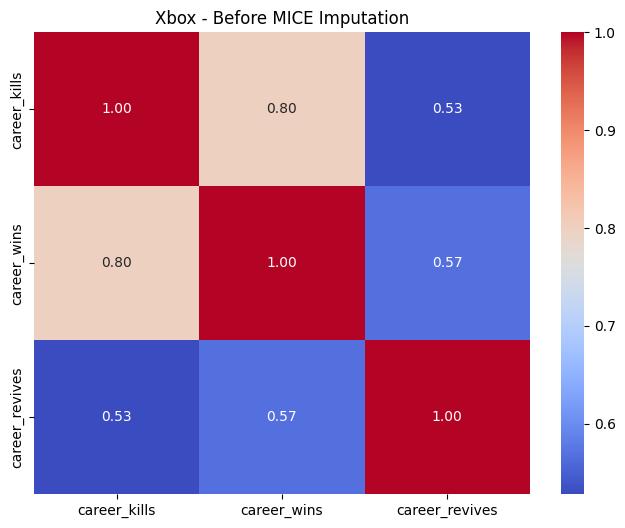


Xbox - Correlation Heatmap AFTER MICE Imputation:


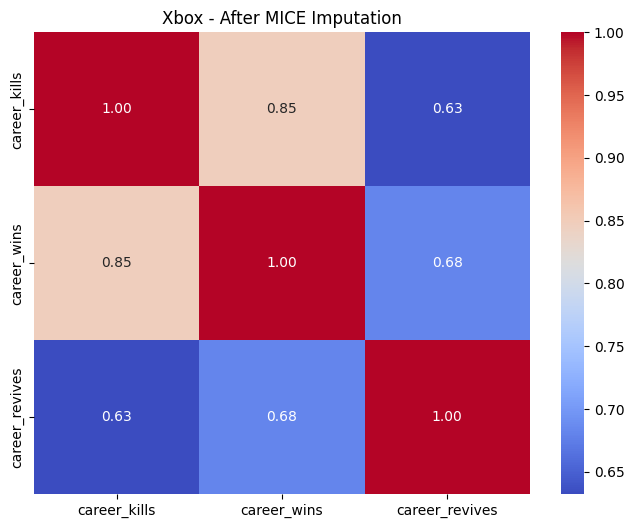


PS4 - Correlation Heatmap BEFORE MICE Imputation:


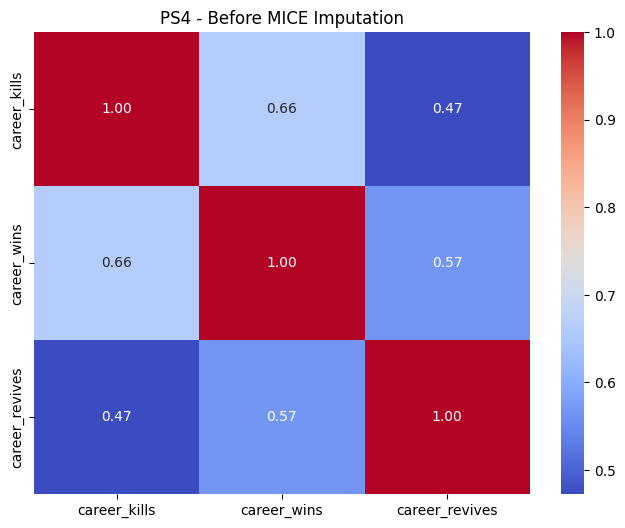


PS4 - Correlation Heatmap AFTER MICE Imputation:


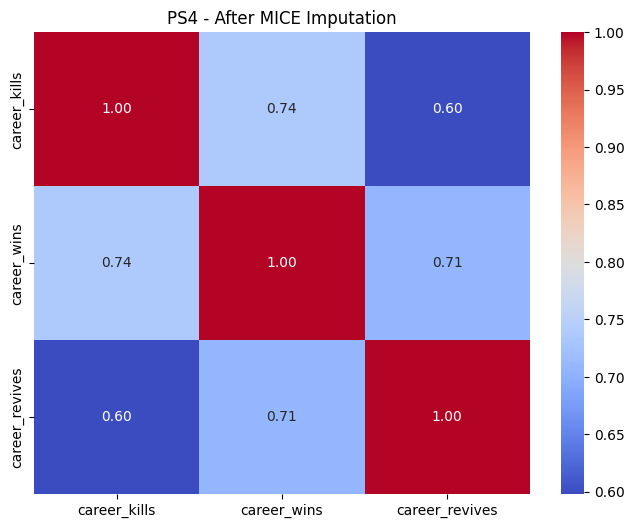


PC - Correlation Heatmap BEFORE MICE Imputation:


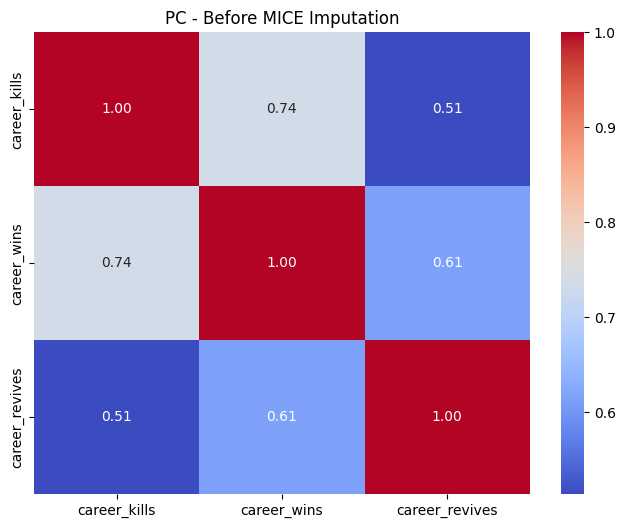


PC - Correlation Heatmap AFTER MICE Imputation:


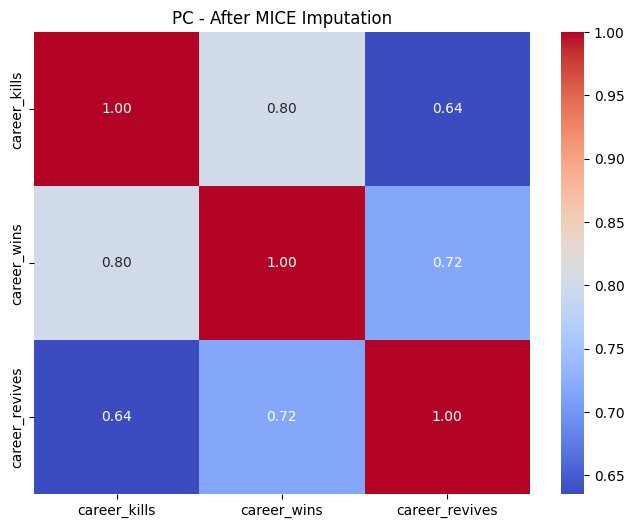

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(df, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt='.2f')
    plt.title(title)
    plt.show()

for name, df in datasets.items():
    print(f"\n{name} - Correlation Heatmap BEFORE MICE Imputation:")
    numeric_df = df.drop(columns=['player_name'])
    plot_correlation_heatmap(numeric_df, f"{name} - Before MICE Imputation")

    print(f"\n{name} - Correlation Heatmap AFTER MICE Imputation:")
    mice_df = imputed_dataframes[name]["MICE Imputation"].drop(columns=['player_name'])
    plot_correlation_heatmap(mice_df, f"{name} - After MICE Imputation")

In [16]:
# Calculate and print mean and variance for only the MICE-imputed datasets for PC, Xbox, and PS4

for name in ["PC", "Xbox", "PS4"]:
    print(f"\n{name} - Mean and Variance (MICE Imputed):")
    mice_df = imputed_dataframes[name]["MICE Imputation"].drop(columns=['player_name'])
    mean_variance = mice_df.describe().loc[['mean', 'std']].T
    mean_variance.columns = ['Mean', 'Variance']
    print(mean_variance)
                        


PC - Mean and Variance (MICE Imputed):
                         Mean      Variance
career_kills    107596.732380  34876.204968
career_wins       6572.407559   2415.365602
career_revives   12864.435138   4118.023989

Xbox - Mean and Variance (MICE Imputed):
                        Mean      Variance
career_kills    91553.851970  29741.441244
career_wins      6086.250266   2305.328022
career_revives  13386.527157   4771.927380

PS4 - Mean and Variance (MICE Imputed):
                         Mean      Variance
career_kills    109205.128179  30609.915754
career_wins       7078.746694   2115.556437
career_revives   14594.444557   4629.394338
